In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime


In [16]:
preis_bis_2015 = pd.read_csv("Gro_handelspreise_201501010000_201810010000_Stunde.csv", sep=";")
preis_ab_2015 = pd.read_csv("Gro_handelspreise_201809300000_202501010000_Stunde.csv", sep=";")

In [ ]:
# Process preis_bis_2015 and preis_ab_2015
# Convert dates to datetime
preis_bis_2015['Datum von'] = pd.to_datetime(preis_bis_2015['Datum von'], format='%d.%m.%Y %H:%M')
preis_ab_2015['Datum von'] = pd.to_datetime(preis_ab_2015['Datum von'], format='%d.%m.%Y %H:%M')
preis_bis_2015['Datum bis'] = pd.to_datetime(preis_bis_2015['Datum bis'], format='%d.%m.%Y %H:%M')
preis_ab_2015['Datum bis'] = pd.to_datetime(preis_ab_2015['Datum bis'], format='%d.%m.%Y %H:%M')

# Select relevant columns and merge
df1 = preis_bis_2015[['Datum von', 'Datum bis', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen', 'DE/AT/LU [€/MWh] Originalauflösungen']]
df2 = preis_ab_2015[['Datum von', 'Datum bis', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]

# Combine the price columns into one
df1['combined_price'] = df1.apply(
    lambda x: x['DE/AT/LU [€/MWh] Originalauflösungen'] if x['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] == '-' 
    else x['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], axis=1
)

# Create final dataframes with date and price
df1_final = df1[['Datum von', 'Datum bis', 'combined_price']].rename(columns={'combined_price': 'price'})
df2_final = df2[['Datum von', 'Datum bis', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']].rename(
    columns={'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'price'}
)

# Concatenate the dataframes
preis = pd.concat([df1_final, df2_final], ignore_index=True)

# Sort by date
preis = preis.sort_values('Datum von').reset_index(drop=True)

# Clean up the price column (replace commas with dots and convert to float)
preis['price'] = preis['price'].replace('-', '0').str.replace(',', '.').astype(float)

# Remove the first 5 days from the dataset
preis = preis[preis['Datum von'] > '2015-01-05']

C:\Users\TimPr\AppData\Local\Temp\ipykernel_13384\426765283.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['combined_price'] = df1.apply(


In [18]:
preis.head()

,Datum von,Datum bis,price
97,2015-01-05 01:00:00,2015-01-05 02:00:00,17.93
98,2015-01-05 02:00:00,2015-01-05 03:00:00,15.17
99,2015-01-05 03:00:00,2015-01-05 04:00:00,16.38
100,2015-01-05 04:00:00,2015-01-05 05:00:00,17.38
101,2015-01-05 05:00:00,2015-01-05 06:00:00,16.38


In [19]:
verbrauch = pd.read_csv('Realisierter_Stromverbrauch_201501010000_202412020000_Viertelstunde.csv',sep=';')
erzeugung = pd.read_csv('Realisierte_Erzeugung_201501010000_202412020000_Viertelstunde.csv',sep=';')
# preis = pd.read_csv('Gro_handelspreise_201501010000_202412020000_Stunde.csv',sep=';')


In [20]:

# First, let's process the timestamps in the dataframes
for df in [verbrauch, erzeugung, preis]:
    df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
    df['Datum bis'] = pd.to_datetime(df['Datum bis'], format='%d.%m.%Y %H:%M')

# Create a copy of preis with resampled data
preis_resampled = preis.copy()
preis_resampled = preis_resampled.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()

# Merge the dataframes on 'Datum von'
combined_df = verbrauch.merge(erzeugung, on=['Datum von', 'Datum bis'], how='outer')
combined_df = combined_df.merge(preis_resampled[['Datum von', 'price']], 
                              on='Datum von', 
                              how='outer')

# Clean up numeric columns by removing thousand separators and converting to float
numeric_columns = combined_df.select_dtypes(include=['object']).columns
for col in numeric_columns:
    if col not in ['Datum von', 'Datum bis']:
        # Replace '-' with '0', remove thousand separators, and convert decimal separator
        combined_df[col] = combined_df[col].str.replace('.', '').str.replace(',', '.').replace('-', '0').astype(float)
        # Forward fill any remaining NaN values
        combined_df[col] = combined_df[col].ffill()

C:\Users\TimPr\AppData\Local\Temp\ipykernel_13384\2530638025.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  preis_resampled = preis_resampled.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()


In [21]:
combined_df.isna().sum()

Datum von                                               0
Datum bis                                            2917
Gesamt (Netzlast) [MWh] Originalauflösungen             0
Residuallast [MWh] Originalauflösungen                  0
Pumpspeicher [MWh] Originalauflösungen_x                0
Biomasse [MWh] Originalauflösungen                      0
Wasserkraft [MWh] Originalauflösungen                   0
Wind Offshore [MWh] Originalauflösungen                 0
Wind Onshore [MWh] Originalauflösungen                  0
Photovoltaik [MWh] Originalauflösungen                  0
Sonstige Erneuerbare [MWh] Originalauflösungen          0
Kernenergie [MWh] Originalauflösungen                   0
Braunkohle [MWh] Originalauflösungen                    0
Steinkohle [MWh] Originalauflösungen                    0
Erdgas [MWh] Originalauflösungen                        0
Pumpspeicher [MWh] Originalauflösungen_y                0
Sonstige Konventionelle [MWh] Originalauflösungen       0
price         

In [22]:
# # Set thresholds for low wind and solar production
# wind_threshold = 0.001 * combined_df['Wind Offshore [MWh] Originalauflösungen'].max()  # 20% of maximum production
# solar_threshold = 0.001 * combined_df['Photovoltaik [MWh] Originalauflösungen'].max()  # 30% of maximum production

# # Create boolean flags for low wind and solar production
# combined_df['Low_Wind'] = combined_df['Wind Offshore [MWh] Originalauflösungen'] < wind_threshold
# combined_df['Low_Solar'] = combined_df['Photovoltaik [MWh] Originalauflösungen'] < solar_threshold

# # Combine conditions for Dunkelflaute (both wind and solar low)
# combined_df['Dunkelflaute'] = combined_df['Low_Wind'] & combined_df['Low_Solar']

# # Group by day or any other time period and count Dunkelflaute occurrences
# dunkelflauten_per_day = combined_df.groupby(combined_df['Datum von'].dt.date)['Dunkelflaute'].sum()

# # Identify days with a significant number of Dunkelflaute hours
# dunkelflauten_days = dunkelflauten_per_day[dunkelflauten_per_day > 10].index  # e.g., more than 10 hours of low production

# # Optionally, plot Dunkelflauten occurrences over time
# plt.figure(figsize=(12, 6))
# plt.plot(dunkelflauten_per_day.index, dunkelflauten_per_day, label="Dunkelflaute occurrences", color='r')
# plt.title("Dunkelflauten Occurrences Over Time")
# plt.xlabel("Date")
# plt.ylabel("Number of Dunkelflaute hours")
# plt.grid(True)
# plt.legend()
# plt.show()


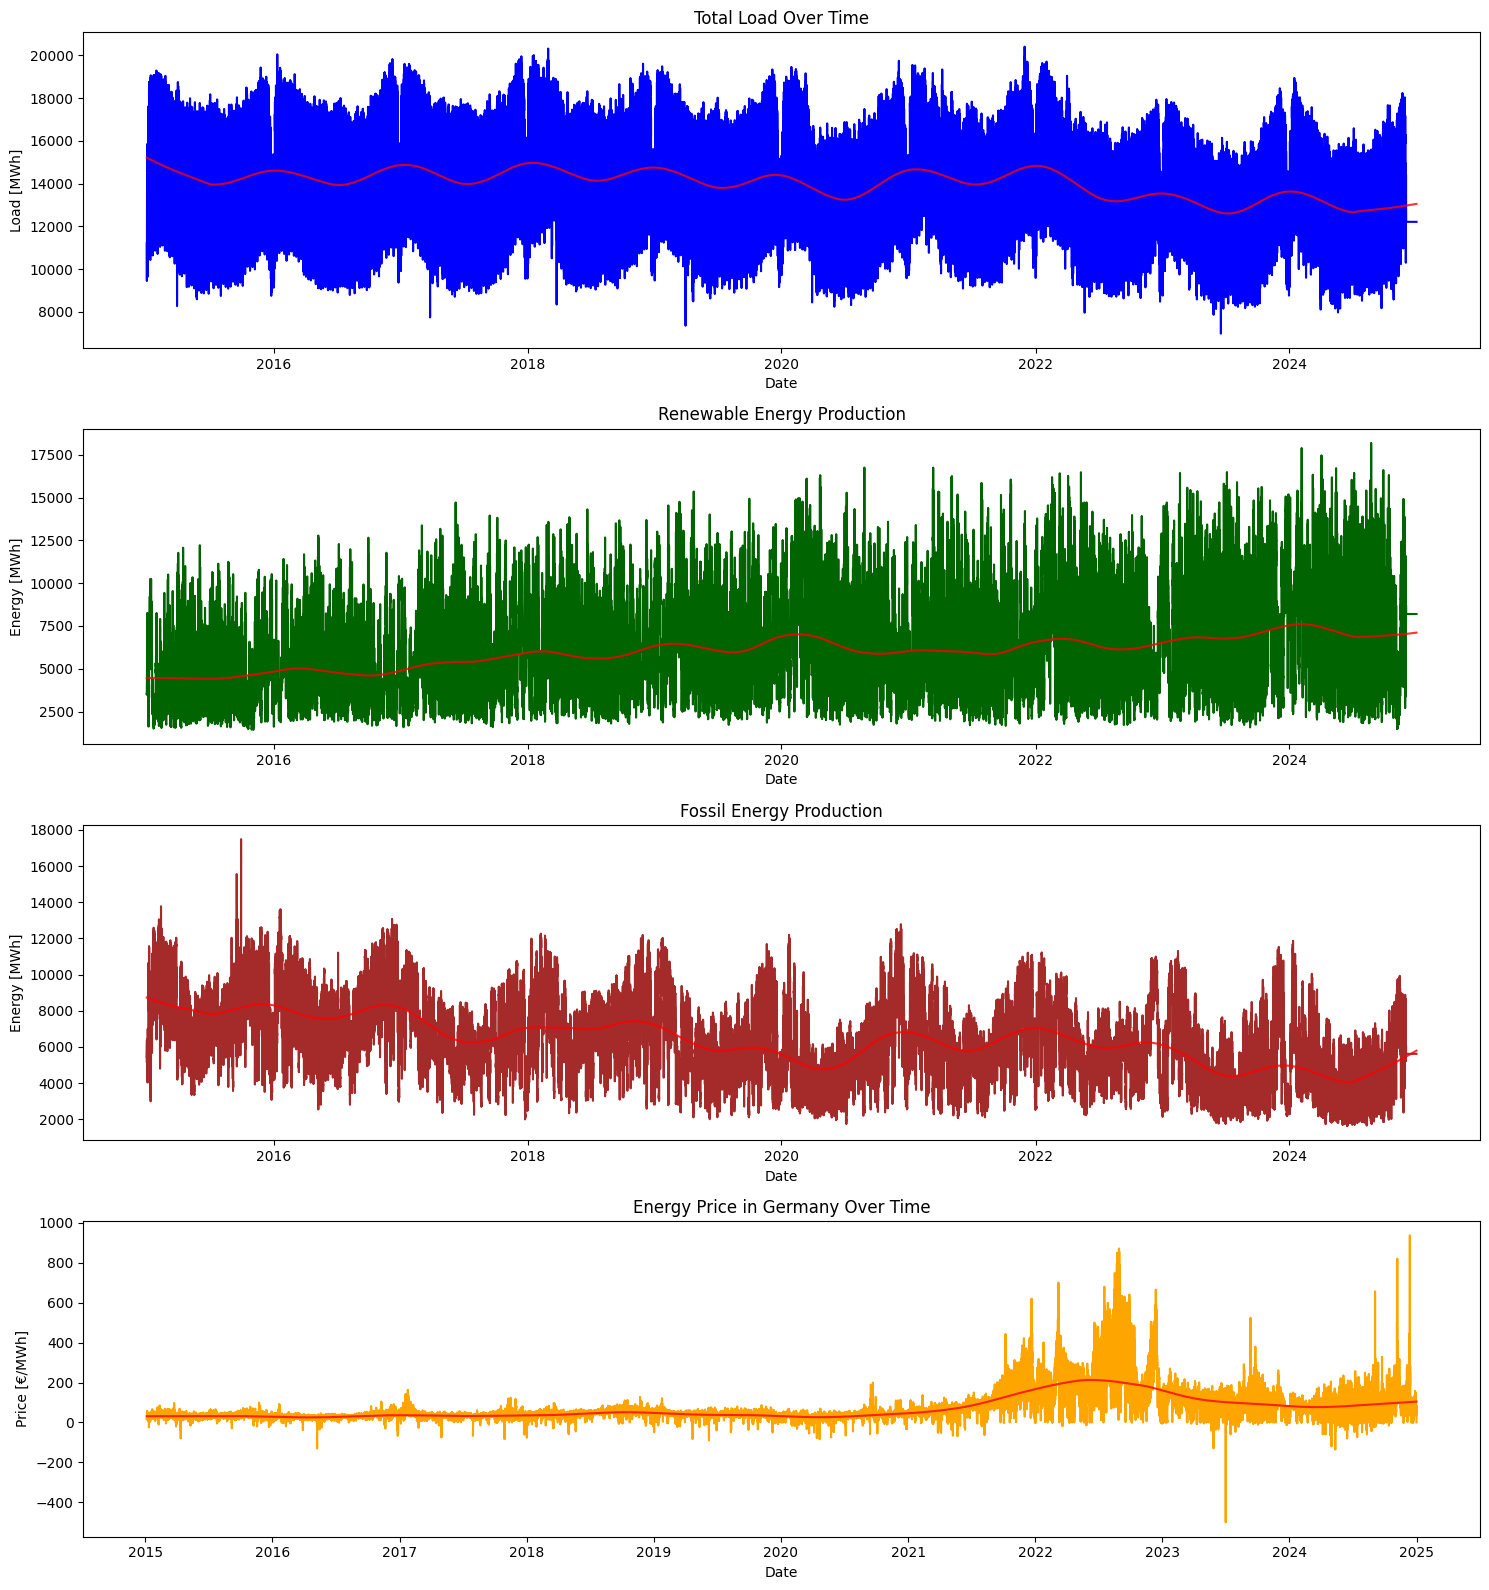

In [44]:
# Downsample factor (e.g., 10 for taking every 10th point)
downsample_factor = 10

# Downsampled indices
downsampled_indices = np.arange(0, len(combined_df), downsample_factor)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Load over time (blue)
ax1.plot(combined_df['Datum von'], combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'], color='blue')
ax1.set_title('Total Load Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load [MWh]')
trend1 = lowess(
    combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'][downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax1.plot(combined_df['Datum von'][downsampled_indices], trend1[:, 1], "r-", alpha=0.8)

# Plot 2: Renewable Energy (dark green)
renewable = (
    combined_df['Biomasse [MWh] Originalauflösungen'] + 
    combined_df['Wasserkraft [MWh] Originalauflösungen'] + 
    combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
    combined_df['Wind Onshore [MWh] Originalauflösungen'] + 
    combined_df['Photovoltaik [MWh] Originalauflösungen'] + 
    combined_df['Sonstige Erneuerbare [MWh] Originalauflösungen']
)
ax2.plot(combined_df['Datum von'], renewable, color='darkgreen')
ax2.set_title('Renewable Energy Production')
ax2.set_xlabel('Date')
ax2.set_ylabel('Energy [MWh]')
trend4 = lowess(
    renewable[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax2.plot(combined_df['Datum von'][downsampled_indices], trend4[:, 1], "r-", alpha=0.8)

# Plot 3: Fossil Energy (brown)
fossil = (
    combined_df['Braunkohle [MWh] Originalauflösungen'] + 
    combined_df['Steinkohle [MWh] Originalauflösungen'] + 
    combined_df['Erdgas [MWh] Originalauflösungen'] + 
    combined_df['Sonstige Konventionelle [MWh] Originalauflösungen']
)
ax3.plot(combined_df['Datum von'], fossil, color='brown')
ax3.set_title('Fossil Energy Production')
ax3.set_xlabel('Date')
ax3.set_ylabel('Energy [MWh]')
trend3 = lowess(
    fossil[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax3.plot(combined_df['Datum von'][downsampled_indices], trend3[:, 1], "r-", alpha=0.8)


# Plot 4: Energy price in Germany (orange)
valid_prices = combined_df['price'].dropna()
valid_dates = combined_df['Datum von'][valid_prices.index]
downsampled_indices_prices = np.arange(0, len(valid_prices), downsample_factor)
ax4.plot(combined_df['Datum von'], combined_df['price'], color='orange')
ax4.set_title('Energy Price in Germany Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price [€/MWh]')
trend2 = lowess(
    valid_prices.iloc[downsampled_indices_prices], 
    downsampled_indices_prices, 
    frac=0.1
)
ax4.plot(valid_dates.iloc[downsampled_indices_prices], trend2[:, 1], "r-", alpha=0.8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


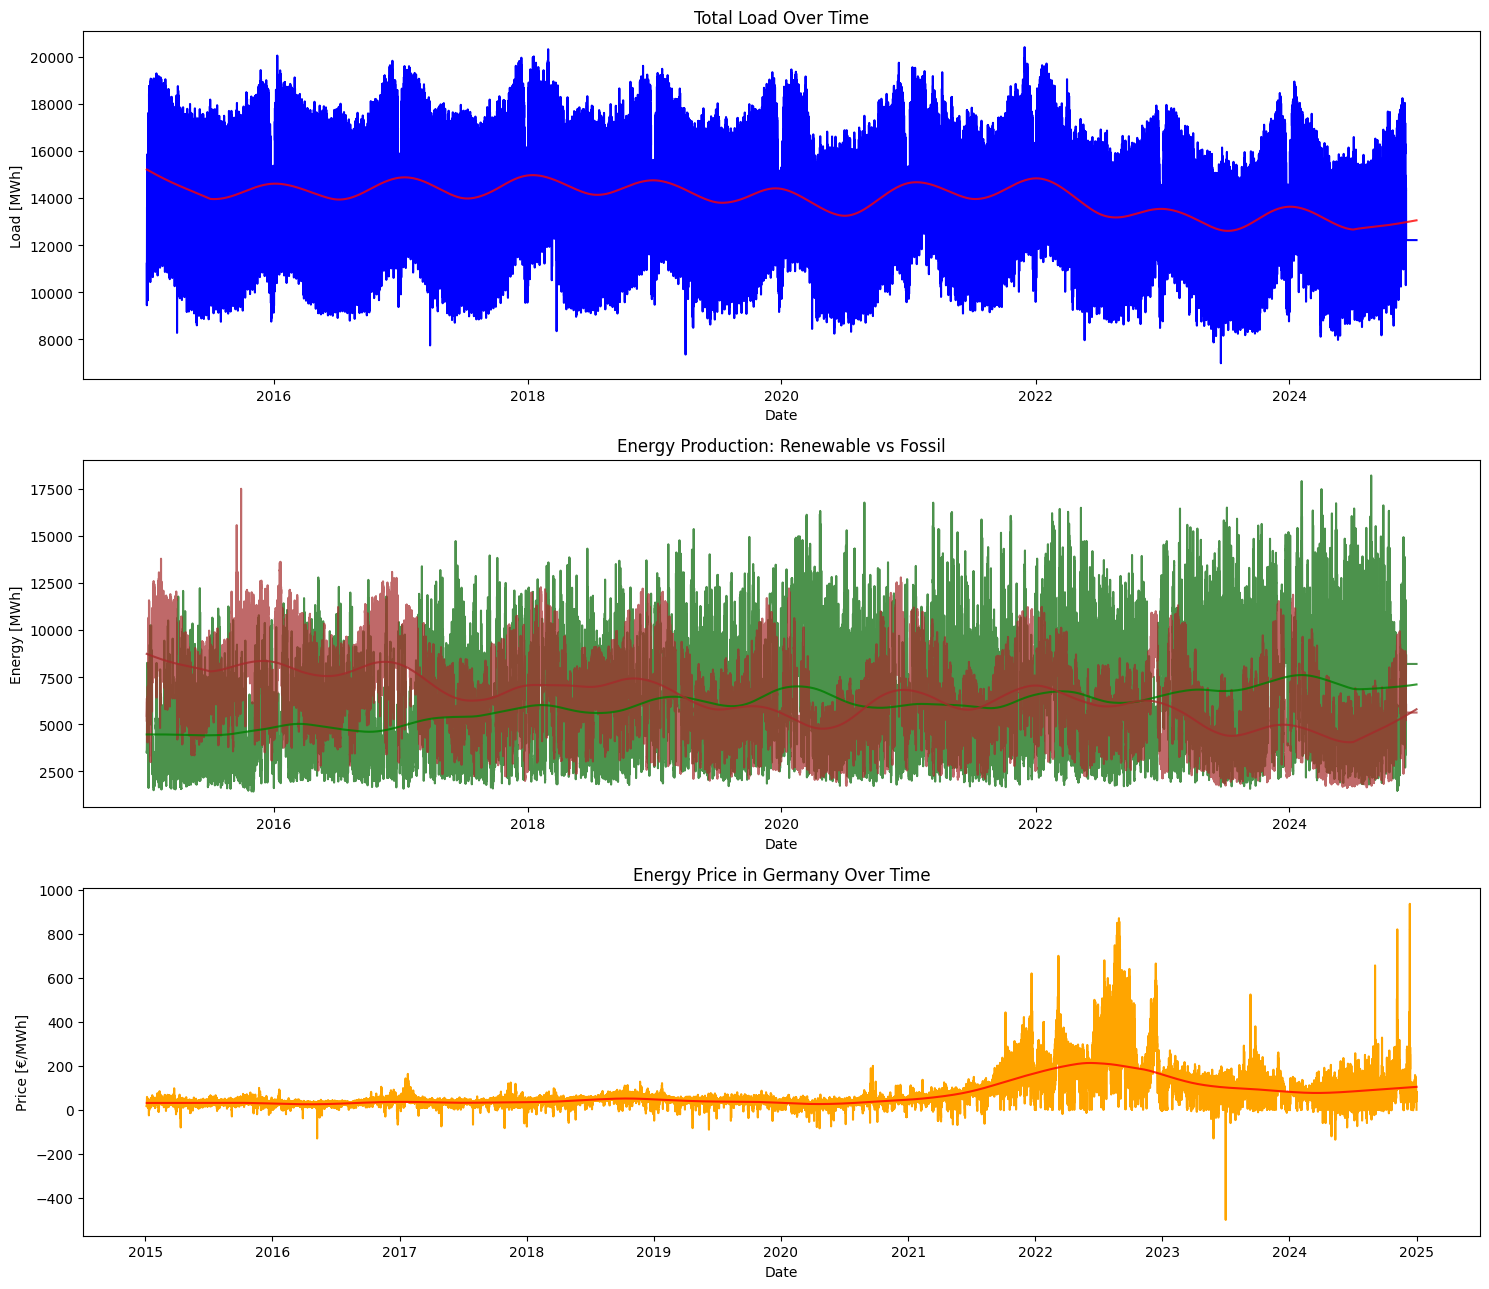

In [48]:
# Downsample factor (e.g., 10 for taking every 10th point)
downsample_factor = 10

# Downsampled indices
downsampled_indices = np.arange(0, len(combined_df), downsample_factor)

# Create subplots
fig, (ax1, ax3, ax4) = plt.subplots(3, 1, figsize=(15, 13))

# Plot 1: Load over time (blue)
ax1.plot(combined_df['Datum von'], combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'], color='blue')
ax1.set_title('Total Load Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load [MWh]')
trend1 = lowess(
    combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'][downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax1.plot(combined_df['Datum von'][downsampled_indices], trend1[:, 1], "r-", alpha=0.8)


# Plot 3: Renewable and Fossil Energy with Transparency
fossil = (
    combined_df['Braunkohle [MWh] Originalauflösungen'] + 
    combined_df['Steinkohle [MWh] Originalauflösungen'] + 
    combined_df['Erdgas [MWh] Originalauflösungen'] + 
    combined_df['Sonstige Konventionelle [MWh] Originalauflösungen']
)

# Plot renewable and fossil energy with transparency
ax3.plot(combined_df['Datum von'], renewable, color='darkgreen', alpha=0.7)
ax3.plot(combined_df['Datum von'], fossil, color='brown', alpha=0.7)

# Adding trend lines for both renewable and fossil energy
trend_renewable = lowess(renewable[downsampled_indices], downsampled_indices, frac=0.1)
ax3.plot(combined_df['Datum von'][downsampled_indices], trend_renewable[:, 1], "g-", alpha=0.8)

trend_fossil = lowess(fossil[downsampled_indices], downsampled_indices, frac=0.1)
ax3.plot(combined_df['Datum von'][downsampled_indices], trend_fossil[:, 1], "brown", alpha=0.8)

ax3.set_title('Energy Production: Renewable vs Fossil')
ax3.set_xlabel('Date')
ax3.set_ylabel('Energy [MWh]')

# Plot 4: Energy price in Germany (orange)
valid_prices = combined_df['price'].dropna()
valid_dates = combined_df['Datum von'][valid_prices.index]
downsampled_indices_prices = np.arange(0, len(valid_prices), downsample_factor)
ax4.plot(combined_df['Datum von'], combined_df['price'], color='orange')
ax4.set_title('Energy Price in Germany Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price [€/MWh]')
trend2 = lowess(
    valid_prices.iloc[downsampled_indices_prices], 
    downsampled_indices_prices, 
    frac=0.1
)
ax4.plot(valid_dates.iloc[downsampled_indices_prices], trend2[:, 1], "r-", alpha=0.8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1500x800 with 0 Axes>

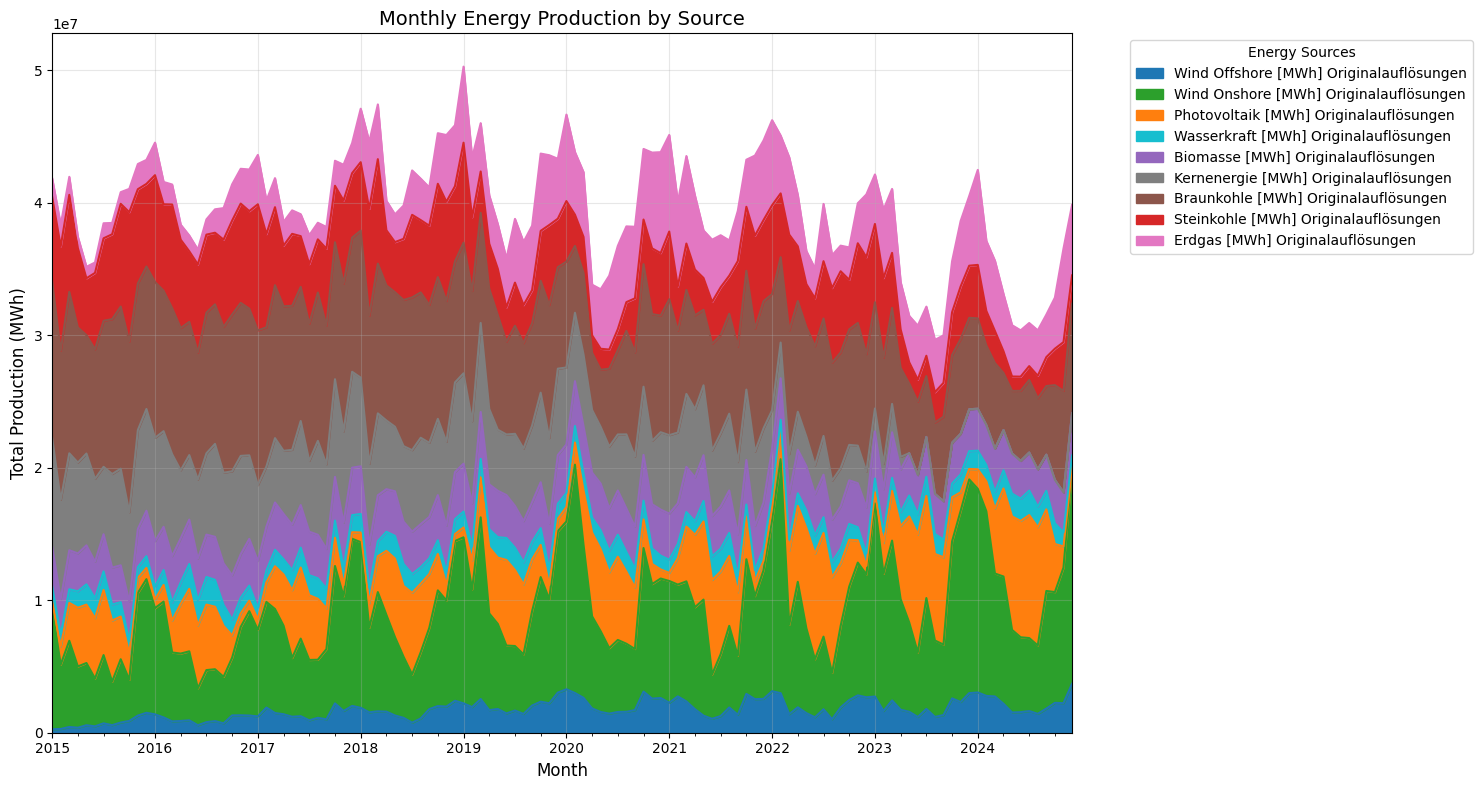

In [ ]:
# Create monthly sums for each energy source
df_monthly = combined_df.groupby(combined_df['Datum von'].dt.to_period('M')).agg({
    'Wind Offshore [MWh] Originalauflösungen': 'sum',
    'Wind Onshore [MWh] Originalauflösungen': 'sum',
    'Photovoltaik [MWh] Originalauflösungen': 'sum',
    'Wasserkraft [MWh] Originalauflösungen': 'sum',
    'Biomasse [MWh] Originalauflösungen': 'sum',
    'Kernenergie [MWh] Originalauflösungen': 'sum',
    'Braunkohle [MWh] Originalauflösungen': 'sum',
    'Steinkohle [MWh] Originalauflösungen': 'sum',
    'Erdgas [MWh] Originalauflösungen': 'sum'
})

# Convert period index to datetime for proper plotting
df_monthly.index = df_monthly.index.to_timestamp()

# Create stacked area plot for monthly values
plt.figure(figsize=(15, 8))

# Define colors and order for energy sources
colors = {
    'Wind Offshore [MWh] Originalauflösungen': '#1f77b4',  # blue
    'Wind Onshore [MWh] Originalauflösungen': '#2ca02c',   # green
    'Photovoltaik [MWh] Originalauflösungen': '#ff7f0e',   # orange
    'Wasserkraft [MWh] Originalauflösungen': '#17becf',    # light blue
    'Biomasse [MWh] Originalauflösungen': '#9467bd',       # purple
    'Kernenergie [MWh] Originalauflösungen': '#7f7f7f',    # gray
    'Braunkohle [MWh] Originalauflösungen': '#8c564b',     # brown
    'Steinkohle [MWh] Originalauflösungen': '#d62728',     # red
    'Erdgas [MWh] Originalauflösungen': '#e377c2'          # pink
}

# Stack monthly values into an area plot
df_monthly.plot.area(
    stacked=True, figsize=(15, 8), color=[colors[col] for col in df_monthly.columns]
)

# Customize plot
plt.title('Monthly Energy Production by Source', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Production (MWh)', fontsize=12)
plt.legend(
    title='Energy Sources', 
    bbox_to_anchor=(1.05, 1), loc='upper left'
)
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()



C:\Users\TimPr\AppData\Local\Temp\ipykernel_13384\2927635352.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df[desired_order].resample('Y').sum()


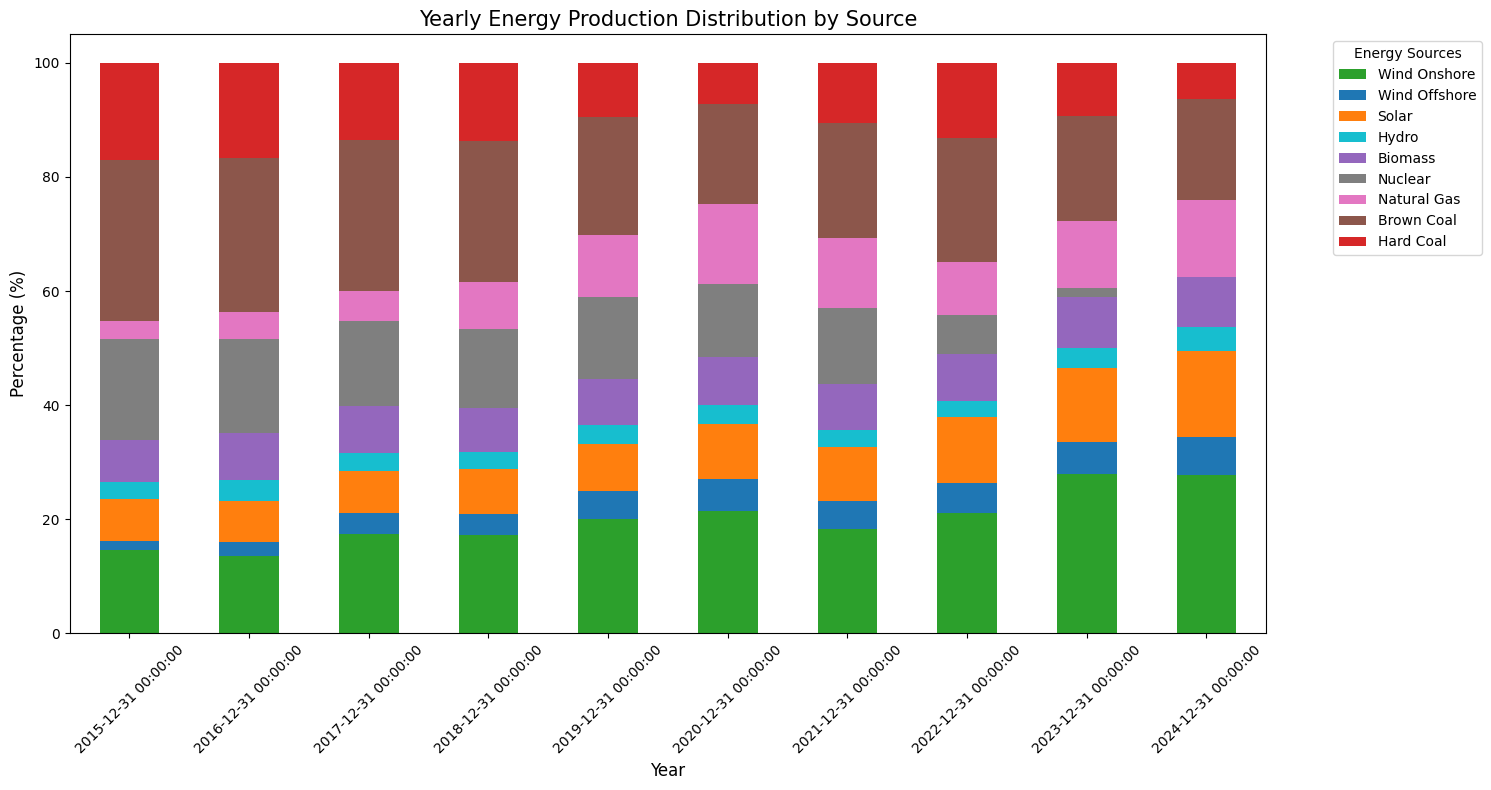

In [ ]:
# Create a copy of the dataframe with datetime index
df = combined_df.copy()
df.set_index('Datum von', inplace=True)

# Define columns of interest and desired order
desired_order = [
    'Wind Onshore [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Biomasse [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen'
]

# Resample the data to yearly frequency and calculate totals and percentages
df_yearly = df[desired_order].resample('Y').sum()
df_yearly['Total'] = df_yearly.sum(axis=1)
df_percentage = df_yearly[desired_order].div(df_yearly['Total'], axis=0) * 100

# Define colors matching the desired order
colors = [
    '#2ca02c', '#1f77b4', '#ff7f0e', '#17becf', '#9467bd', 
    '#7f7f7f', '#e377c2', '#8c564b', '#d62728'
]

# Plot stacked bar chart
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors)
plt.title('Yearly Energy Production Distribution by Source', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)

# Simplify the legend
legend_labels = [
    'Wind Onshore', 'Wind Offshore', 'Solar', 'Hydro', 'Biomass', 
    'Nuclear', 'Natural Gas', 'Brown Coal', 'Hard Coal'
]
plt.legend(title='Energy Sources', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




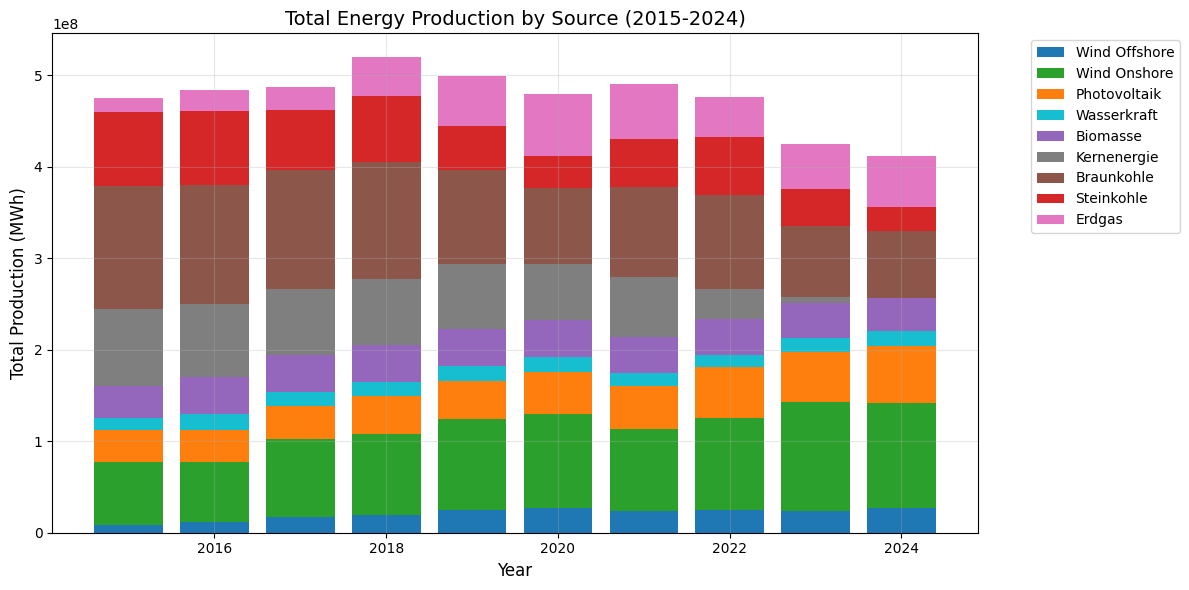


Total yearly production (MWh):
2015: 475,287,034.75
2016: 484,260,448.25
2017: 487,630,384.00
2018: 519,946,988.75
2019: 499,236,173.50
2020: 479,515,425.00
2021: 490,084,360.00
2022: 476,773,512.25
2023: 425,472,190.00
2024: 411,658,101.50


In [ ]:
# Create yearly sums for each energy source
df_yearly = combined_df.groupby(combined_df['Datum von'].dt.year).agg({
    'Wind Offshore [MWh] Originalauflösungen': 'sum',
    'Wind Onshore [MWh] Originalauflösungen': 'sum',
    'Photovoltaik [MWh] Originalauflösungen': 'sum',
    'Wasserkraft [MWh] Originalauflösungen': 'sum',
    'Biomasse [MWh] Originalauflösungen': 'sum',
    'Kernenergie [MWh] Originalauflösungen': 'sum',
    'Braunkohle [MWh] Originalauflösungen': 'sum',
    'Steinkohle [MWh] Originalauflösungen': 'sum',
    'Erdgas [MWh] Originalauflösungen': 'sum'
})

# Create stacked bar plot
plt.figure(figsize=(12, 6))
bottom = np.zeros(len(df_yearly))

# Define colors and order for energy sources
colors = {
    'Wind Offshore [MWh] Originalauflösungen': '#1f77b4',  # blue
    'Wind Onshore [MWh] Originalauflösungen': '#2ca02c',   # green
    'Photovoltaik [MWh] Originalauflösungen': '#ff7f0e',   # orange
    'Wasserkraft [MWh] Originalauflösungen': '#17becf',    # light blue
    'Biomasse [MWh] Originalauflösungen': '#9467bd',       # purple
    'Kernenergie [MWh] Originalauflösungen': '#7f7f7f',    # gray
    'Braunkohle [MWh] Originalauflösungen': '#8c564b',     # brown
    'Steinkohle [MWh] Originalauflösungen': '#d62728',     # red
    'Erdgas [MWh] Originalauflösungen': '#e377c2'          # pink
}

# Create stacked bars
for column in df_yearly.columns:
    plt.bar(df_yearly.index, df_yearly[column], bottom=bottom, 
            label=column.replace(' [MWh] Originalauflösungen', ''),
            color=colors[column])
    bottom += df_yearly[column]

# Customize plot
plt.title('Total Energy Production by Source (2015-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Production (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()

# Print total production for each year
total_yearly = df_yearly.sum(axis=1)
print("\nTotal yearly production (MWh):")
for year, total in total_yearly.items():
    print(f"{year}: {total:,.2f}")

When do we need energy and how much?

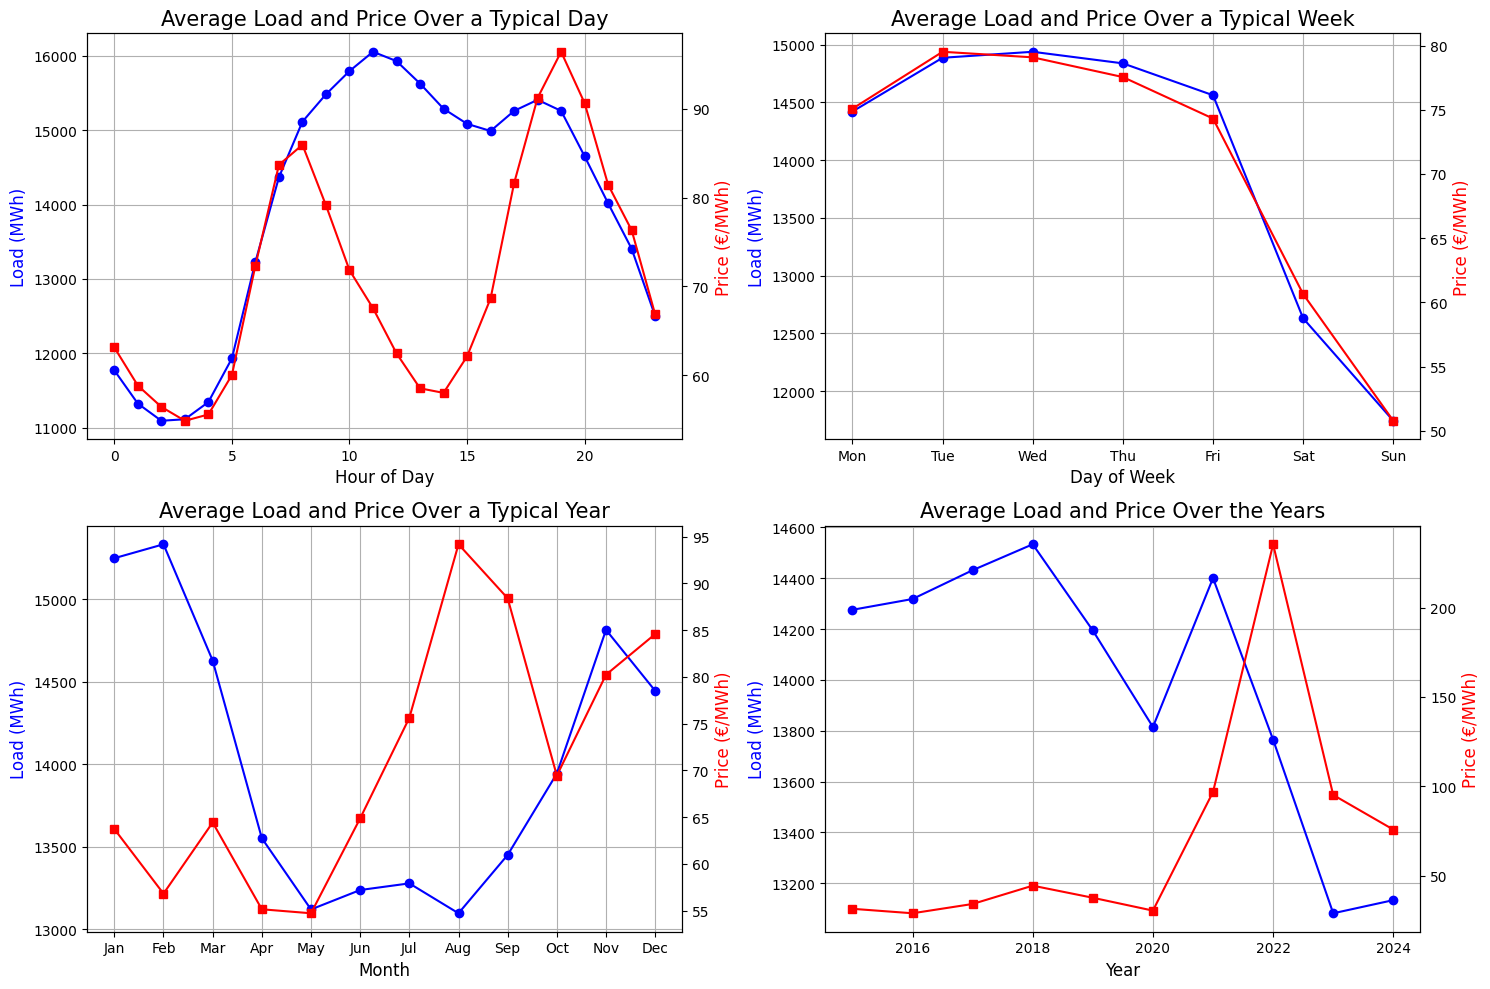

In [ ]:
# Use the verbrauch dataframe we loaded earlier
df = verbrauch.copy()

# Preprocessing
df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
df['Gesamt (Netzlast) [MWh] Originalauflösungen'] = df['Gesamt (Netzlast) [MWh] Originalauflösungen'].str.replace('.', '').str.replace(',', '.').astype(float)

# Rename column for simplicity
df.rename(columns={'Gesamt (Netzlast) [MWh] Originalauflösungen': 'Netzlast'}, inplace=True)

# Add price data
df = df.merge(preis_resampled[['Datum von', 'price']], 
              on='Datum von', 
              how='left')
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)

# Extract relevant features
df['Hour'] = df['Datum von'].dt.hour
df['Month'] = df['Datum von'].dt.month
df['Year'] = df['Datum von'].dt.year
df['DayOfWeek'] = df['Datum von'].dt.dayofweek
df['DayOfMonth'] = df['Datum von'].dt.day

# Group for averages
daily_avg_load = df.groupby('Hour')['Netzlast'].mean()
daily_avg_price = df.groupby('Hour')['price'].mean()

weekly_avg_load = df.groupby('DayOfWeek')['Netzlast'].mean()
weekly_avg_price = df.groupby('DayOfWeek')['price'].mean()

monthly_avg_load = df.groupby('Month')['Netzlast'].mean()
monthly_avg_price = df.groupby('Month')['price'].mean()

yearly_avg_load = df.groupby('Year')['Netzlast'].mean()
yearly_avg_price = df.groupby('Year')['price'].mean()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Daily pattern
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

ax1.plot(daily_avg_load.index, daily_avg_load, marker='o', color='b', label='Load')
ax1_twin.plot(daily_avg_price.index, daily_avg_price, marker='s', color='r', label='Price')

ax1.set_title('Average Load and Price Over a Typical Day', fontsize=15)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax1_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax1.grid()

# Plot 2: Weekly pattern
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

ax2.plot(weekly_avg_load.index, weekly_avg_load, marker='o', color='b', label='Load')
ax2_twin.plot(weekly_avg_price.index, weekly_avg_price, marker='s', color='r', label='Price')

ax2.set_title('Average Load and Price Over a Typical Week', fontsize=15)
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax2_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.grid()

# Plot 3: Monthly pattern
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

ax3.plot(monthly_avg_load.index, monthly_avg_load, marker='o', color='b', label='Load')
ax3_twin.plot(monthly_avg_price.index, monthly_avg_price, marker='s', color='r', label='Price')

ax3.set_title('Average Load and Price Over a Typical Year', fontsize=15)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax3_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.grid()

# Plot 4: Yearly trend
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

ax4.plot(yearly_avg_load.index, yearly_avg_load, marker='o', color='b', label='Load')
ax4_twin.plot(yearly_avg_price.index, yearly_avg_price, marker='s', color='r', label='Price')

ax4.set_title('Average Load and Price Over the Years', fontsize=15)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Load (MWh)', color='b', fontsize=12)
ax4_twin.set_ylabel('Price (€/MWh)', color='r', fontsize=12)
ax4.grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


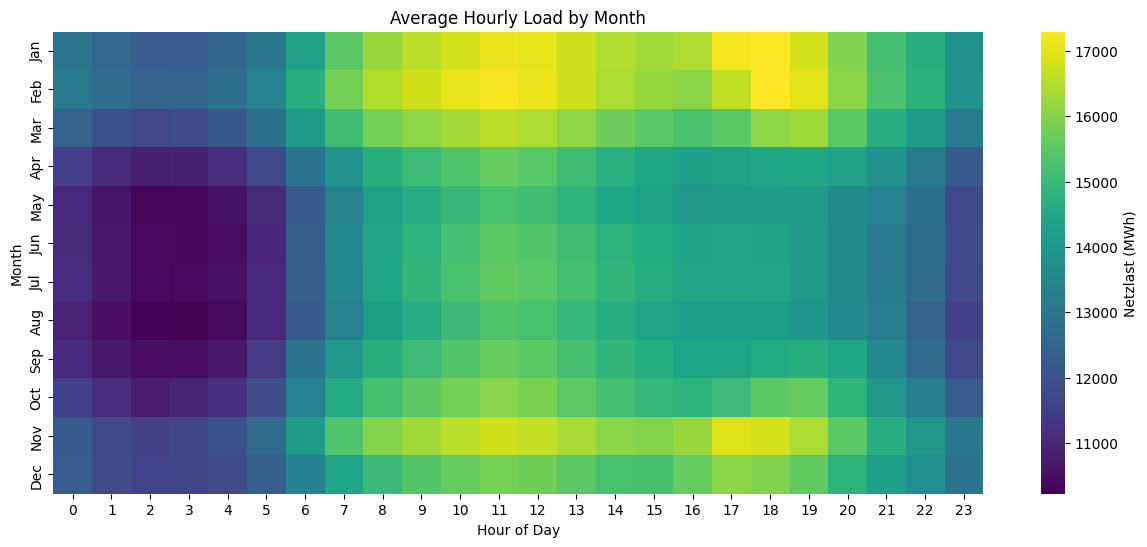

In [ ]:
# Extract hour from datetime and create pivot table for monthly-hourly averages
combined_df['Hour'] = combined_df['Datum von'].dt.hour
combined_df['Month'] = combined_df['Datum von'].dt.month

hourly_monthly_avg = combined_df.pivot_table(
    values='Gesamt (Netzlast) [MWh] Originalauflösungen', 
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

# Create heatmap with switched axes
plt.figure(figsize=(15, 6))
sns.heatmap(hourly_monthly_avg.T, 
            cmap='viridis',
            annot=False,
            cbar_kws={'label': 'Netzlast (MWh)'},
            yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Average Hourly Load by Month')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.show()


How much do we produce and when?

In [ ]:
# Define the columns of interest
columns_of_interest = [
    'Wind Offshore [MWh] Originalauflösungen',
    'Wind Onshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Biomasse [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen'
]

# Create a copy of the dataframe with datetime index
df = combined_df.copy()
df.set_index('Datum von', inplace=True)

# Resample the data to yearly frequency, summing up the production for each energy source
df_yearly = df.resample('Y')[columns_of_interest].sum()

# Calculate the total production for each year
df_yearly['Total'] = df_yearly.sum(axis=1)

# Calculate the percentage contribution of each energy source to the total production
df_percentage = df_yearly[columns_of_interest].div(df_yearly['Total'], axis=0) * 100



C:\Users\TimPr\AppData\Local\Temp\ipykernel_13384\4042665287.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y')[columns_of_interest].sum()


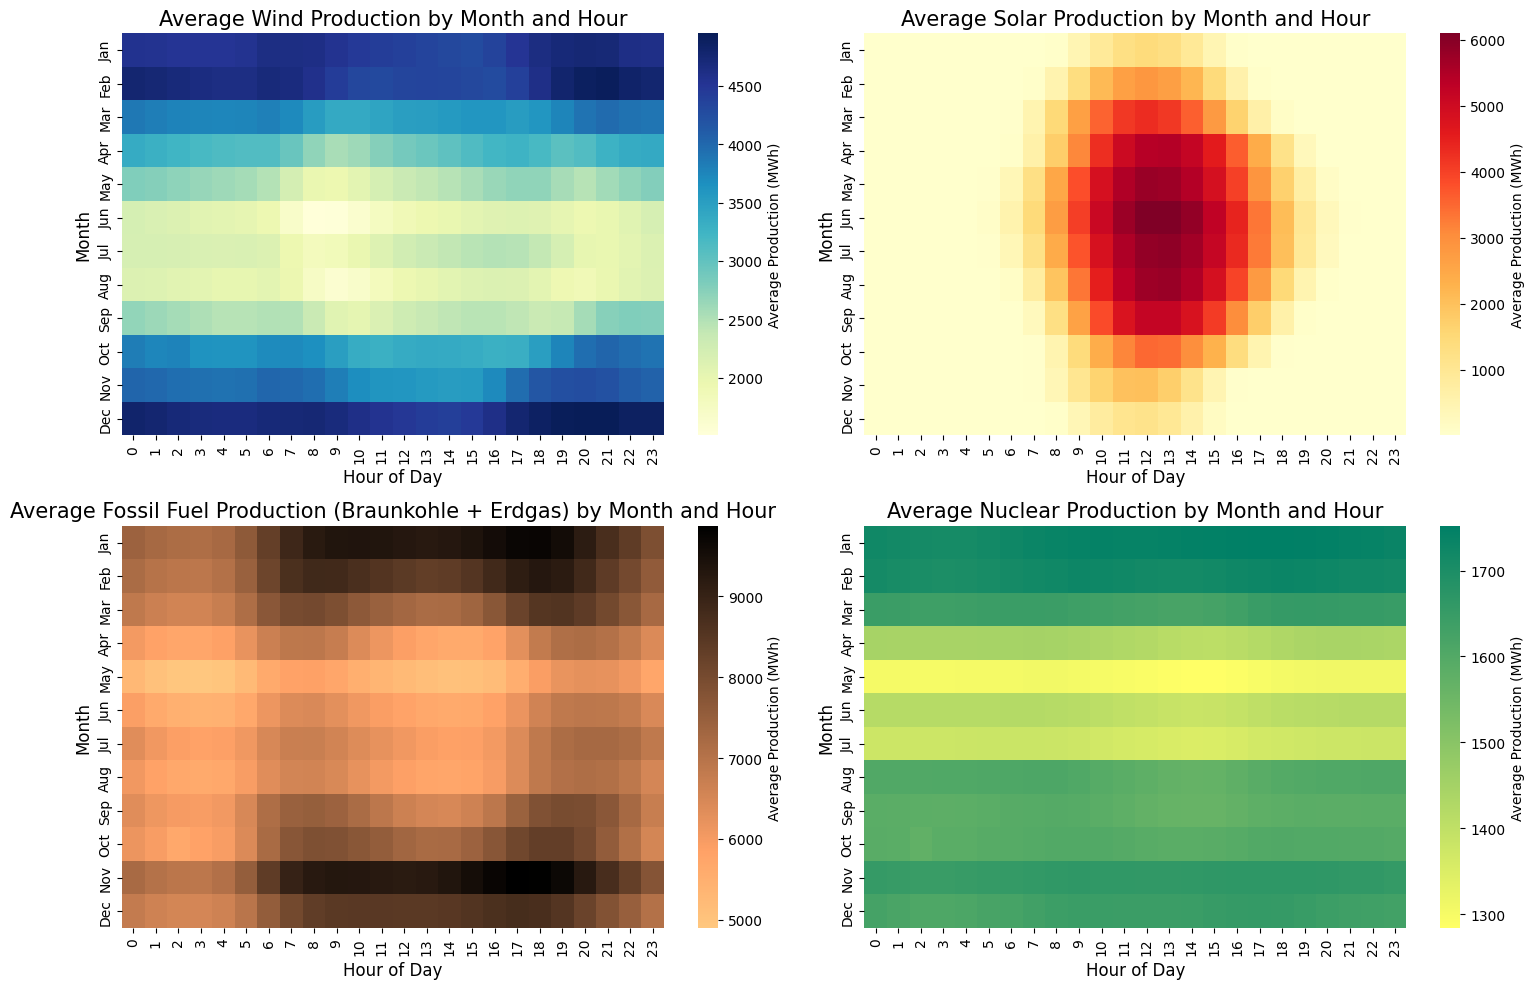

In [ ]:
# Define a function to create and plot heatmaps in subplots
def plot_heatmap_subplot(ax, df, value_col, title, cmap):
    pivot = pd.pivot_table(
        data=df,
        values=value_col,
        index='Month',
        columns='Hour',
        aggfunc='mean'
    )
    sns.heatmap(
        pivot,
        cmap=cmap,
        cbar_kws={'label': 'Average Production (MWh)'},
        xticklabels=range(24),
        yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        ax=ax
    )
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Month', fontsize=12)

# Create subplots (2x2 grid)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Calculate total wind and fossil production
combined_df['Total Wind [MWh]'] = (combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
                                  combined_df['Wind Onshore [MWh] Originalauflösungen'])
combined_df['Total Fossil [MWh]'] = (combined_df['Braunkohle [MWh] Originalauflösungen'] + 
                                    combined_df['Erdgas [MWh] Originalauflösungen'] +
                                    combined_df['Steinkohle [MWh] Originalauflösungen'] +
                                    combined_df['Erdgas [MWh] Originalauflösungen'])

# Create and plot heatmaps for Wind, Photovoltaik, Fossil, and Nuclear
plot_heatmap_subplot(ax1, combined_df, 'Total Wind [MWh]', 'Average Wind Production by Month and Hour', 'YlGnBu')
plot_heatmap_subplot(ax2, combined_df, 'Photovoltaik [MWh] Originalauflösungen', 'Average Solar Production by Month and Hour', 'YlOrRd')
plot_heatmap_subplot(ax3, combined_df, 'Total Fossil [MWh]', 'Average Fossil Fuel Production (Braunkohle + Erdgas) by Month and Hour', 'copper_r')
plot_heatmap_subplot(ax4, combined_df, 'Kernenergie [MWh] Originalauflösungen', 'Average Nuclear Production by Month and Hour', 'summer_r')

# Adjust layout and display
plt.tight_layout()
# Save the figure as an SVG file
plt.savefig('heatmaps.svg', format='svg')

plt.show()


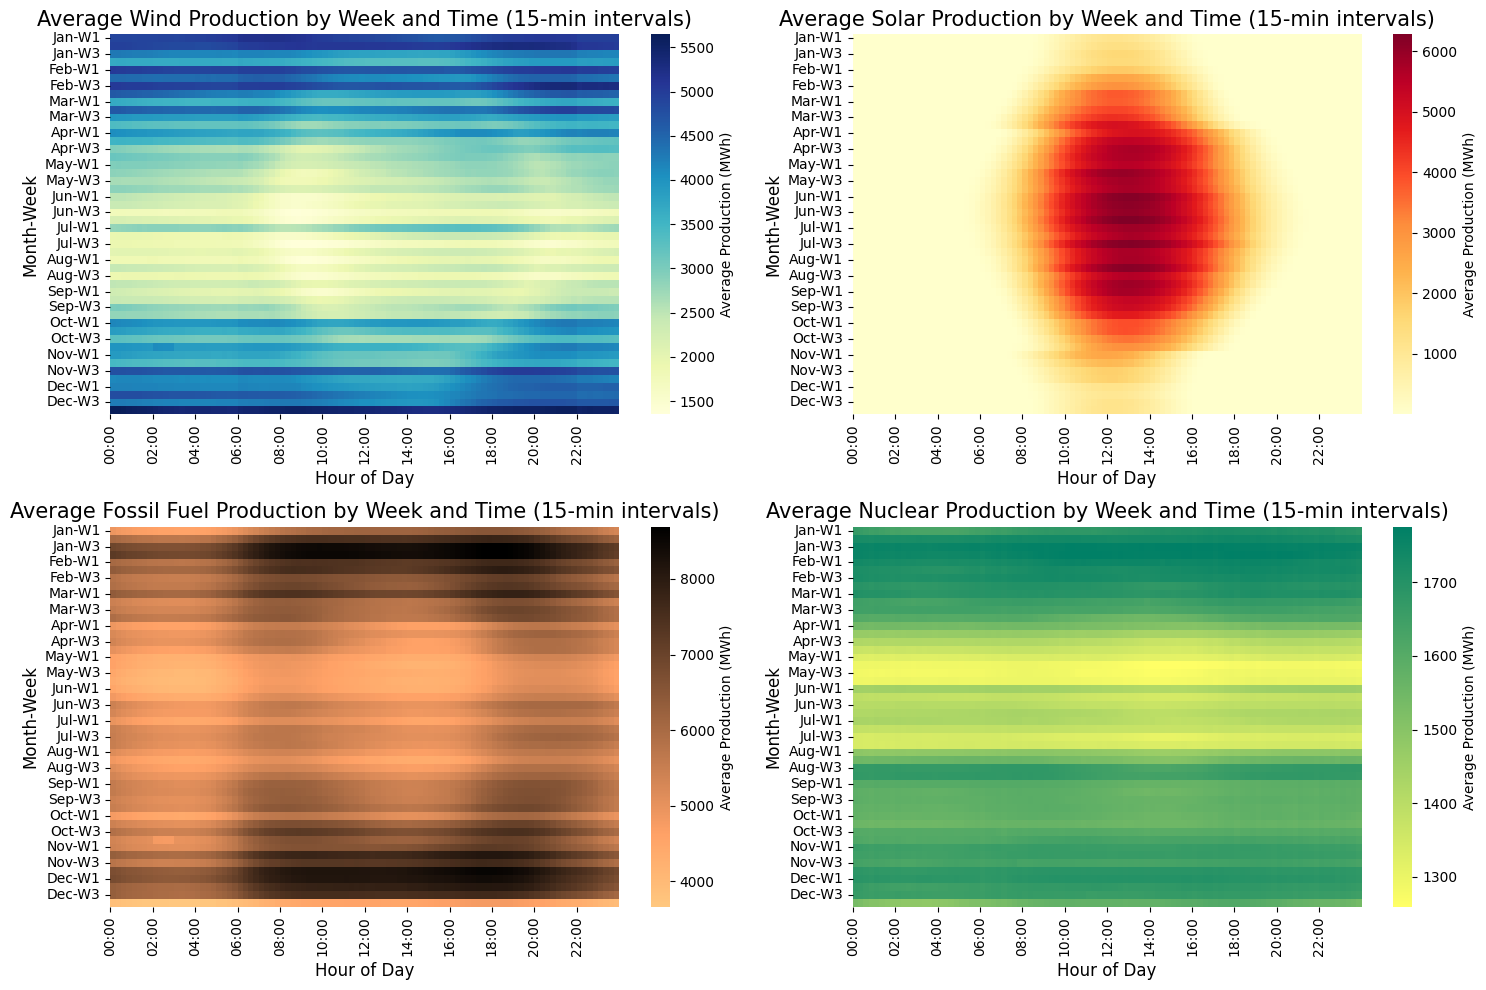

In [ ]:
def plot_high_res_heatmap_subplot(ax, df, value_col, title, cmap):
    # Calculate 15-minute intervals for each day
    df['minute_of_day'] = df['Datum von'].dt.hour * 4 + df['Datum von'].dt.minute // 15
    
    # Create week of month indicator (1-4)
    df['week_of_month'] = (df['Datum von'].dt.day - 1) // 7 + 1
    
    # Create month-week label
    df['month_week'] = df['Datum von'].dt.strftime('%b') + '-W' + df['week_of_month'].astype(str)
    
    # Create pivot table with higher resolution
    pivot = pd.pivot_table(
        data=df,
        values=value_col,
        index='month_week',
        columns='minute_of_day',
        aggfunc='mean'
    )
    
    # Sort index to ensure chronological order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    pivot = pivot.reindex([f'{m}-W{w}' for m in month_order for w in range(1, 5)])
    
    # Create heatmap
    sns.heatmap(
        pivot,
        cmap=cmap,
        cbar_kws={'label': 'Average Production (MWh)'},
        xticklabels=list(range(0, 24, 2)),  # Show every 2 hours
        ax=ax
    )
    
    # Adjust x-axis labels
    x_ticks = np.arange(0, 96, 8)  # Every 2 hours (8 15-min intervals)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{i//4:02d}:00' for i in x_ticks])
    
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Month-Week', fontsize=12)

# Create subplots (2x2 grid)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Calculate total wind and fossil production
combined_df['Total Wind [MWh]'] = (combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
                                  combined_df['Wind Onshore [MWh] Originalauflösungen'])
combined_df['Total Fossil [MWh]'] = (combined_df['Braunkohle [MWh] Originalauflösungen'] + 
                                    combined_df['Erdgas [MWh] Originalauflösungen'] +
                                    combined_df['Steinkohle [MWh] Originalauflösungen'])

# Create and plot high-resolution heatmaps
plot_high_res_heatmap_subplot(ax1, combined_df, 'Total Wind [MWh]', 
                            'Average Wind Production by Week and Time (15-min intervals)', 'YlGnBu')
plot_high_res_heatmap_subplot(ax2, combined_df, 'Photovoltaik [MWh] Originalauflösungen', 
                            'Average Solar Production by Week and Time (15-min intervals)', 'YlOrRd')
plot_high_res_heatmap_subplot(ax3, combined_df, 'Total Fossil [MWh]', 
                            'Average Fossil Fuel Production by Week and Time (15-min intervals)', 'copper_r')
plot_high_res_heatmap_subplot(ax4, combined_df, 'Kernenergie [MWh] Originalauflösungen', 
                            'Average Nuclear Production by Week and Time (15-min intervals)', 'summer_r')

# Adjust layout and display
plt.tight_layout()
plt.savefig('high_res_heatmaps.svg', format='svg')
plt.show()

What does it cost?

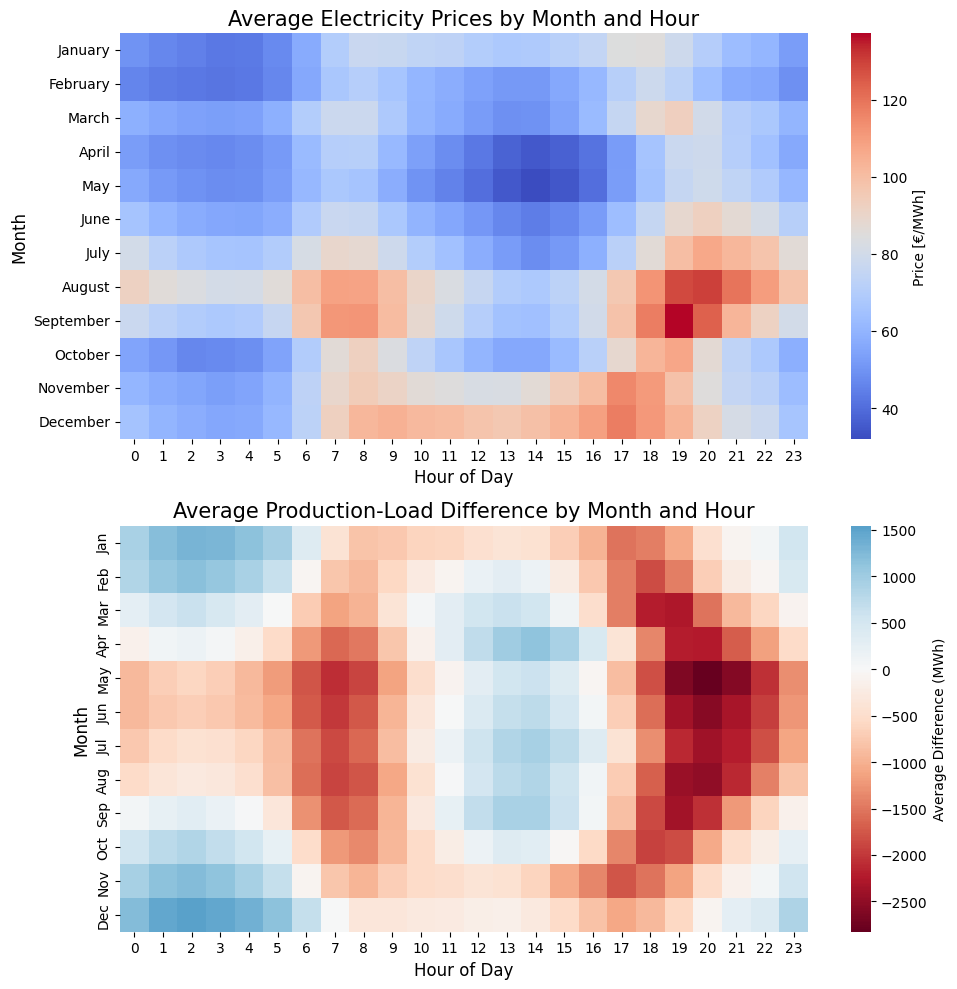

In [ ]:
# Define the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

# Calculate average price for each month and hour
monthly_hourly_profile = combined_df.assign(
    month=combined_df['Datum von'].dt.month_name(),
    hour=combined_df['Datum von'].dt.hour
).groupby(['month', 'hour'])['price'].mean().unstack()

# Reorder months
monthly_hourly_profile = monthly_hourly_profile.reindex(index=months_order)

# Calculate total production (sum of all energy sources)
combined_df['Total Production'] = (
    combined_df['Wind Offshore [MWh] Originalauflösungen'] +
    combined_df['Wind Onshore [MWh] Originalauflösungen'] +
    combined_df['Photovoltaik [MWh] Originalauflösungen'] +
    combined_df['Wasserkraft [MWh] Originalauflösungen'] +
    combined_df['Biomasse [MWh] Originalauflösungen'] +
    combined_df['Kernenergie [MWh] Originalauflösungen'] +
    combined_df['Braunkohle [MWh] Originalauflösungen'] +
    combined_df['Steinkohle [MWh] Originalauflösungen'] +
    combined_df['Erdgas [MWh] Originalauflösungen']
)

# Calculate the difference between production and load
combined_df['Production_Load_Difference'] = combined_df['Total Production'] - combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Calculate average hourly difference for each month
combined_df['Hour'] = combined_df['Datum von'].dt.hour
combined_df['Month'] = combined_df['Datum von'].dt.month

# Create pivot table for monthly-hourly averages
hourly_monthly_diff = pd.pivot_table(
    data=combined_df,
    values='Production_Load_Difference',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create subplots for the two heatmaps
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# First heatmap: Average electricity prices by month and hour
sns.heatmap(
    monthly_hourly_profile, 
    cmap='coolwarm',
    xticklabels=range(24),
    yticklabels=months_order,
    cbar_kws={'label': 'Price [€/MWh]'},
    ax=axes[0]
)
axes[0].set_title('Average Electricity Prices by Month and Hour', fontsize=15)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Month', fontsize=12)

# Second heatmap: Average production-load difference by month and hour
sns.heatmap(
    hourly_monthly_diff,
    cmap='RdBu',
    center=0,
    annot=False,
    cbar_kws={'label': 'Average Difference (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ax=axes[1]
)
axes[1].set_title('Average Production-Load Difference by Month and Hour', fontsize=15)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Month', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


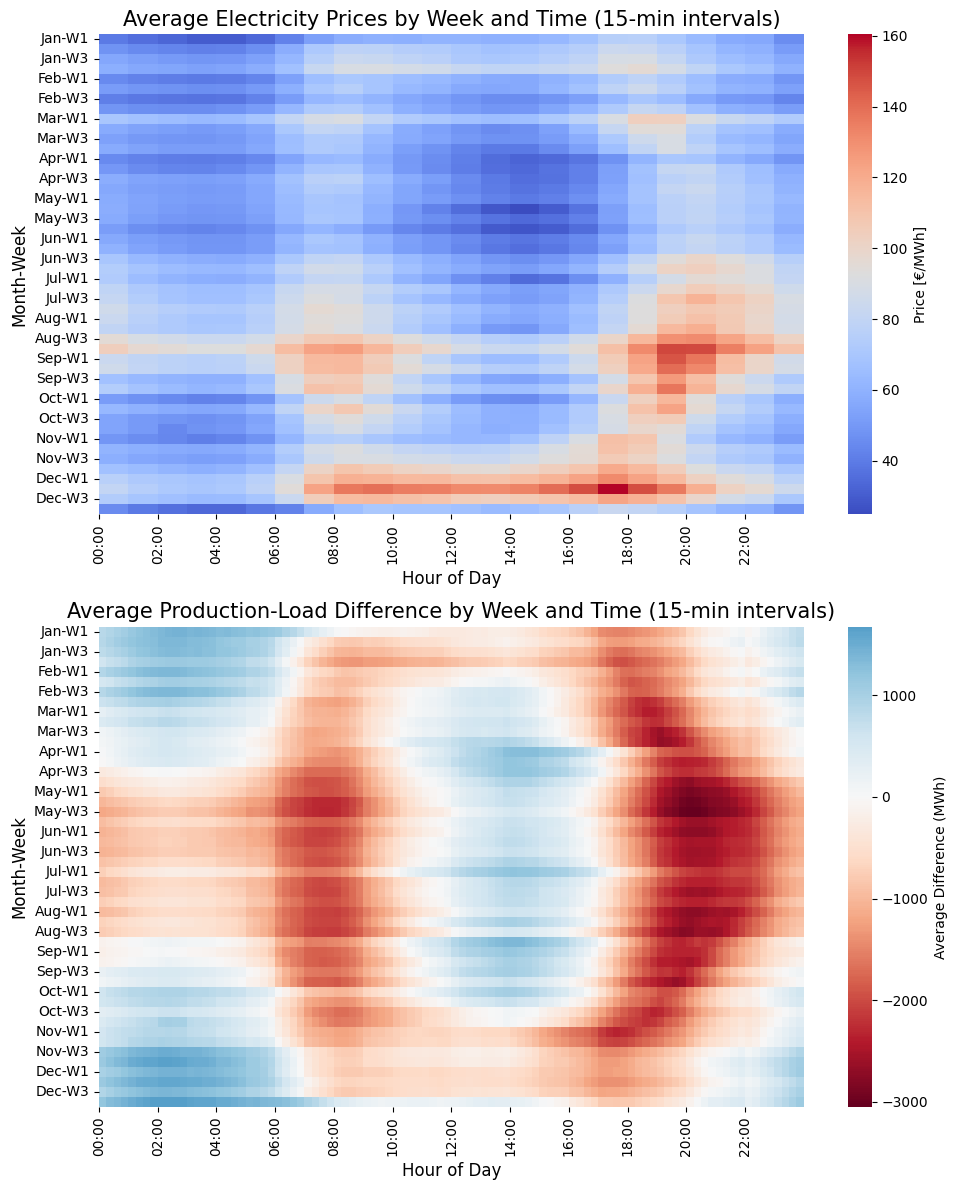

In [ ]:
# Convert 'Datum von' to datetime if not already
combined_df['Datum von'] = pd.to_datetime(combined_df['Datum von'])

# Calculate 15-minute intervals for each day
combined_df['minute_of_day'] = combined_df['Datum von'].dt.hour * 4 + combined_df['Datum von'].dt.minute // 15

# Create week of month indicator (1-4)
combined_df['week_of_month'] = (combined_df['Datum von'].dt.day - 1) // 7 + 1

# Create month-week label
combined_df['month_week'] = combined_df['Datum von'].dt.strftime('%b') + '-W' + combined_df['week_of_month'].astype(str)

# Calculate total production
combined_df['Total Production'] = (
    combined_df['Wind Offshore [MWh] Originalauflösungen'] +
    combined_df['Wind Onshore [MWh] Originalauflösungen'] +
    combined_df['Photovoltaik [MWh] Originalauflösungen'] +
    combined_df['Wasserkraft [MWh] Originalauflösungen'] +
    combined_df['Biomasse [MWh] Originalauflösungen'] +
    combined_df['Kernenergie [MWh] Originalauflösungen'] +
    combined_df['Braunkohle [MWh] Originalauflösungen'] +
    combined_df['Steinkohle [MWh] Originalauflösungen'] +
    combined_df['Erdgas [MWh] Originalauflösungen']
)

# Calculate the difference between production and load
combined_df['Production_Load_Difference'] = (
    combined_df['Total Production'] - 
    combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen']
)

# Create monthly-weekly-15min profiles
weekly_15min_profile = combined_df.groupby(['month_week', 'minute_of_day'])['price'].mean().unstack()

# Sort index to ensure chronological order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekly_15min_profile = weekly_15min_profile.reindex(
    [f'{m}-W{w}' for m in month_order for w in range(1, 5)]
)

# Create production-load difference profile with weekly resolution
weekly_15min_diff = pd.pivot_table(
    data=combined_df,
    values='Production_Load_Difference',
    index='month_week',
    columns='minute_of_day',
    aggfunc='mean'
).reindex([f'{m}-W{w}' for m in month_order for w in range(1, 5)])

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# First heatmap: Average electricity prices
sns.heatmap(
    weekly_15min_profile, 
    cmap='coolwarm',
    xticklabels=list(range(0, 24, 2)),
    cbar_kws={'label': 'Price [€/MWh]'},
    ax=axes[0]
)
axes[0].set_title('Average Electricity Prices by Week and Time (15-min intervals)', fontsize=15)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Month-Week', fontsize=12)

# Adjust x-axis labels
x_ticks = np.arange(0, 96, 8)  # Every 2 hours (8 15-min intervals)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels([f'{i//4:02d}:00' for i in x_ticks])

# Second heatmap: Production-load difference
sns.heatmap(
    weekly_15min_diff,
    cmap='RdBu',
    center=0,
    annot=False,
    cbar_kws={'label': 'Average Difference (MWh)'},
    xticklabels=list(range(0, 24, 2)),
    ax=axes[1]
)
axes[1].set_title('Average Production-Load Difference by Week and Time (15-min intervals)', fontsize=15)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Month-Week', fontsize=12)

# Adjust x-axis labels for second plot
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels([f'{i//4:02d}:00' for i in x_ticks])

plt.tight_layout()
plt.show()